In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import common

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
kbrd = common.keyboardIOS7()

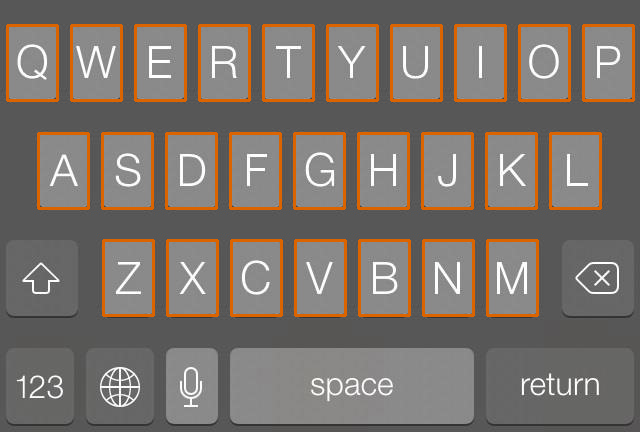

In [4]:
common.draw_keyboard(kbrd)

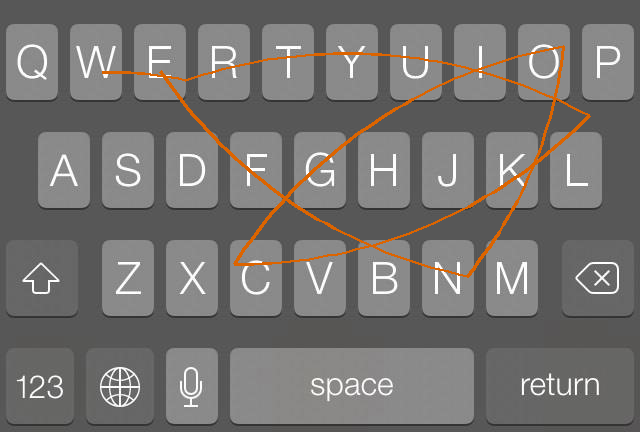

In [5]:
line = common.word_to_line(kbrd['buttons'], 'welcome', 20)
common.draw_word_line(line, kbrd['img'])

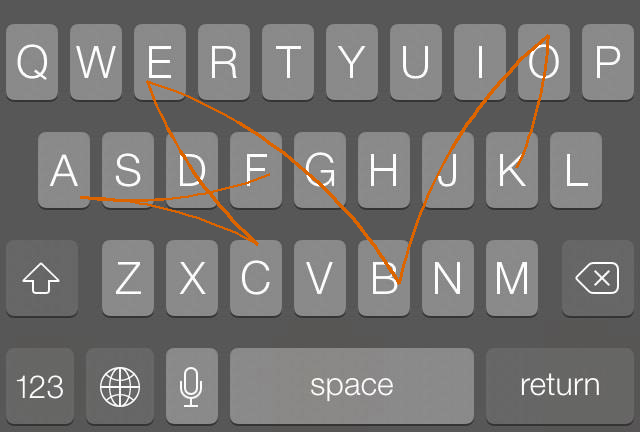

In [6]:
line = common.word_to_line(kbrd['buttons'], 'facebook', 20)
common.draw_word_line(line, kbrd['img'])

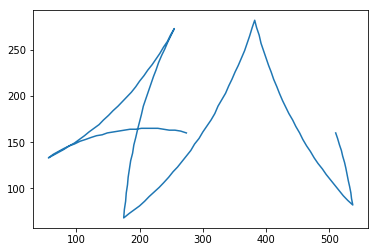

In [7]:
curve = common.word_to_line(kbrd['buttons'], 'facebook', 20)
x, y = zip(*curve)
plt.plot(x, y)
None

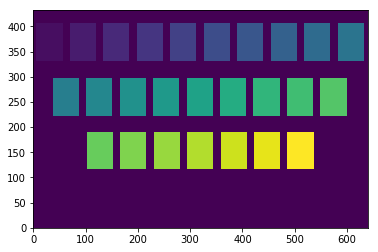

In [8]:
km = kbrd['key_matrix']
plt.pcolor(np.flipud(km.T))
None